## HDAT 9910 Capstone


Research Question 1: Mortality Prediction in ICU 

Task: The task is to build a predictive algorithm using the techniques we learned in this course. 

Objective: To assess the role of machine learning algorithms for predicting mortality by using the MIMIC-III dataset. 

Question: Is it possible to accurately predict mortality based on data from the first 24 hours in ICU?   

Study Population: MIMIC-III dataset 

#### Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### read CVS's

In [2]:
admissions = pd.read_csv("/Users/zacharylukac/Desktop/HDAT-9910-Capstone/mimic_data/admissions.csv")

In [3]:
# Display the first few rows of the dataset
print(admissions.head())

# Get information about the dataset (data types, non-null counts)
print(admissions.info())

# Descriptive statistics of numerical columns
print(admissions.describe())

   row_id  subject_id  hadm_id            admittime            dischtime  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  deathtime admission_type         admission_location  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          discharge_location insurance language           religion  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CA

In [4]:
# Check for missing values
print(admissions.isnull().sum())

# Handle missing values (if needed)
# For example, drop rows with missing values:
# df = df.dropna()


row_id                      0
subject_id                  0
hadm_id                     0
admittime                   0
dischtime                   0
deathtime               53122
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
language                25332
religion                  458
marital_status          10128
ethnicity                   0
edregtime               28099
edouttime               28099
diagnosis                  25
hospital_expire_flag        0
has_chartevents_data        0
dtype: int64


In [5]:
# Check for duplicate rows
print(admissions.duplicated().sum())

# Remove duplicates
# df = df.drop_duplicates()


0


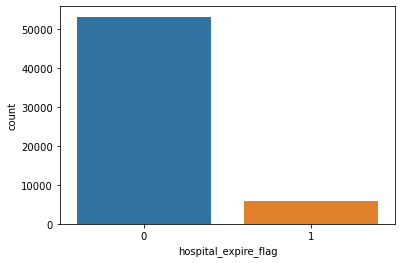

In [7]:

# Countplot for categorical variables
sns.countplot(x='hospital_expire_flag', data=admissions)
plt.show()


In [ ]:
antibiotics = pd.read_csv("/Users/zacharylukac/Desktop/HDAT-9910-Capstone/mimic_data/antibiotics.csv")

In [ ]:
antibiotics.shape[0]

In [ ]:
bloodculture = pd.read_csv("/Users/zacharylukac/Desktop/HDAT-9910-Capstone/mimic_data/bloodculture.csv")

In [ ]:
bloodculture

In [ ]:
gcs_hourly = pd.read_csv("/Users/zacharylukac/Desktop/HDAT-9910-Capstone/mimic_data/gcs_hourly.csv")

In [ ]:
gcs_hourly